In [1]:
from psychophysicsUtils import * 
%load_ext autoreload
%autoreload 2

In [2]:
names = [
         #'tadej',
         'tomtest',
         #'nici',
         #'nicole',
         #'lillianne',
         #'marta',
         #'dammy',
         #'shanice',
         #'morio',
         #'chris',
        ]

machine = 'EL'


tomtest

 
Loading and synchronising pupillometry data (EyeLink)


  0%|          | 0/1028979 [00:00<?, ?it/s]

dt = 0.0010s
Percentage data missing : 2.53 %
Removing speed outliers 
2999.999973922968
Upsampling pupil data to 200Hz: dt = 0.0050s
Downsampling pupil data to 50Hz: dt = 0.0200s
Interpolating missing values


ValueError: could not broadcast input array from shape (20) into shape (0)

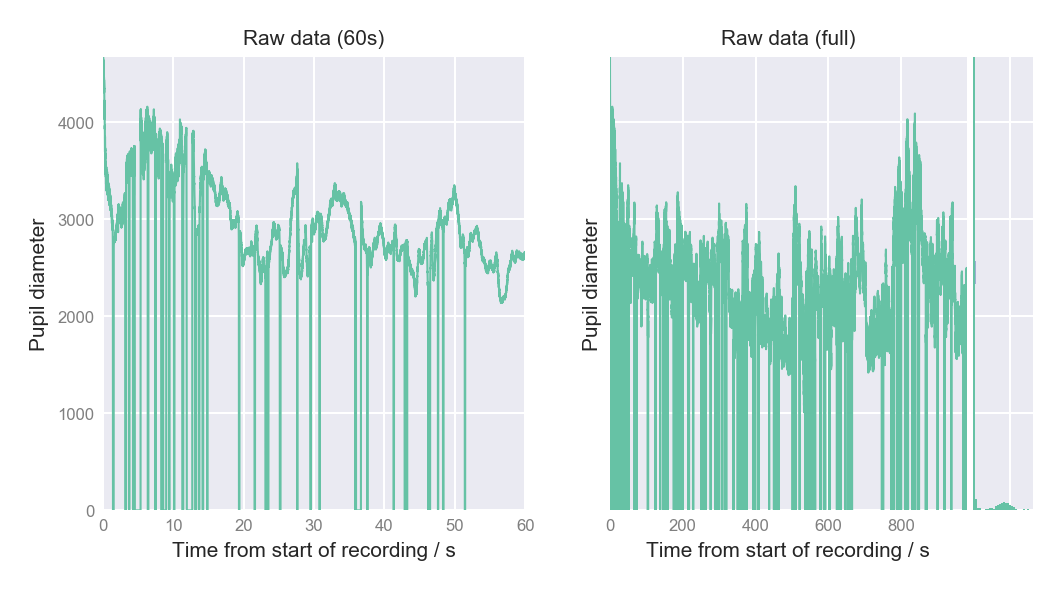

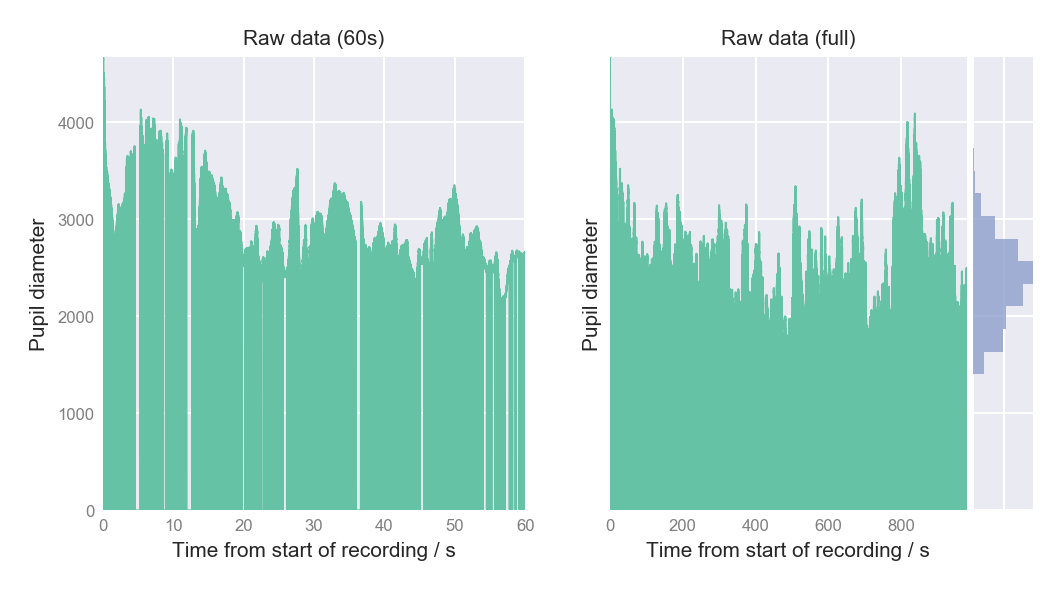

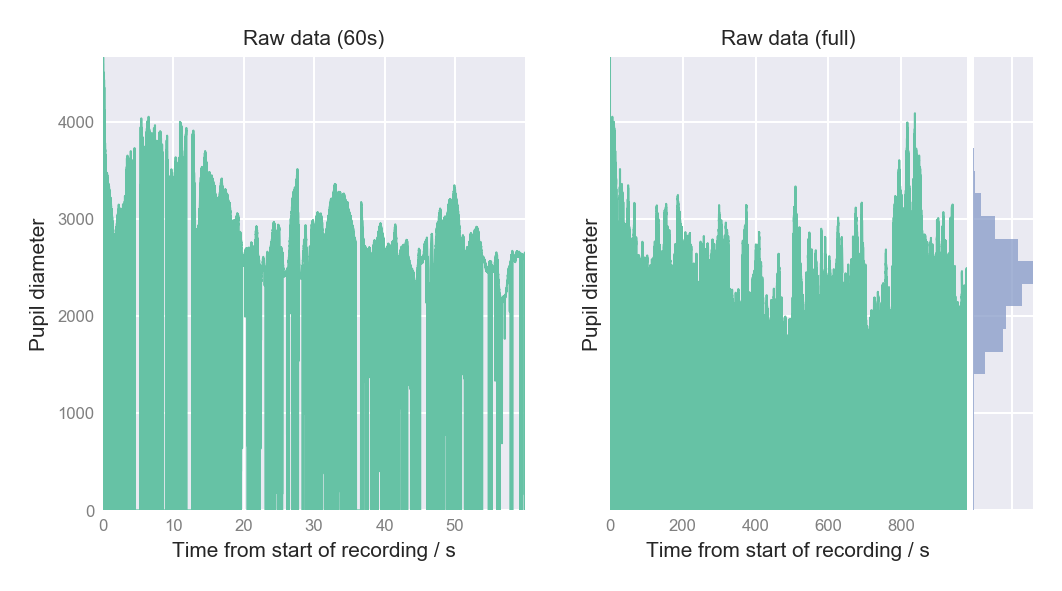

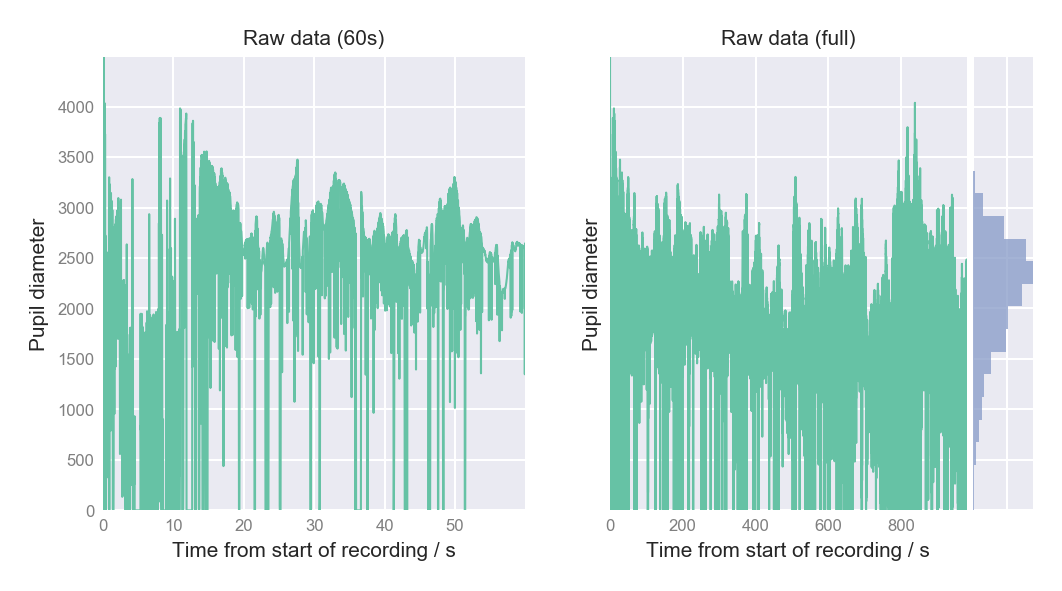

In [3]:
data = {}
for name in names:
    print('\n'+name)
    if machine == 'PL':
        pupilDiams, times, dt = loadAndSyncPupilData_PupilLabs(name)
    elif machine == 'EL':
        pupilDiams, times, dt = loadAndSyncPupilData(name)
    plotPupilDiams(pupilDiams, times, dt)
        
    pupilDiams = removeSpeedOutliers(pupilDiams, times, n=1)
    plotPupilDiams(pupilDiams, times, dt)

    pupilDiams, times, dt = upsample(pupilDiams, times, dt, new_dt = 0.005)
    plotPupilDiams(pupilDiams, times, dt)

    rawPupilDiams, times, dt = downsample(pupilDiams, times, dt)
    plotPupilDiams(rawPupilDiams, times, dt)

    pupilDiams = interpolatePupilDiams(rawPupilDiams, times, dt)
    plotPupilDiams(pupilDiams, times, dt)

    pupilDiams = frequencyFilter(pupilDiams,times,dt,cutoff_freq=4, cutoff_width = 1, highpass=False)
    plotPupilDiams(pupilDiams, times, dt)


    pupilDiams = frequencyFilter(pupilDiams,times,dt,cutoff_freq=0.1, cutoff_width = 0.01, highpass=True)
    plotPupilDiams(pupilDiams, times, dt, ymin='-ymax')


    pupilDiams = zScore(pupilDiams, normrange=[60,times[-1]-60]) #(take off a minute either end for z-scoring )
    plotPupilDiams(pupilDiams, times, dt, ymin='-ymax', zoomRange=[200,260])
    
    data[name] = {}
    data[name]['pupilDiams'] = pupilDiams
    data[name]['rawPupilDiams'] = rawPupilDiams
    data[name]['rawtimes'] = times
    data[name]['dt'] = dt

In [ ]:
for name in names:
    trialData, times = loadAndProcessTrialData(name, data[name]['rawtimes'])    
    data[name]['times'] = times
    data[name]['trialData'] = trialData


In [ ]:
print('Example:')
print('White cross appears: %.3f' %data[names[0]]['trialData'][10]['whiteCrossAppears'])
print('White noise starts:  %.3f' %data[names[0]]['trialData'][10]['whiteNoiseStart'])
print('Tone starts:         %.3f' %data[names[0]]['trialData'][10]['toneStart'])
print('Gap starts:          %.3f' %data[names[0]]['trialData'][10]['gapStart'])
print('Tone after gap?:     %r' %data[names[0]]['trialData'][10]['toneAfterGap'])

In [ ]:
plotNames = [
         #'tadej',
         'tomtest'
         #'nicole',
         #'nici',
         #'lillianne',
         #'marta',
         #'dammy',
         #'shanice',
         #'morio',
         #'chris',
        ]
name = 'all'
whoToPlot = plotNames
plotData = {}
for person in whoToPlot:
    plotData[person] = data[person]



## Reaction time change over time 

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,2))

max_ = 0
for (i,name_) in enumerate(plotNames):
    trialIndex = []
    reactionTime = []
    for j in range(len(data[name_]['trialData'])):
        if (j > 3
            and data[name_]['trialData'][j]['trialCorrect'] == 'correct' 
           ):
            trialIndex.append(j)
            reactionTime.append(data[name_]['trialData'][j]['reactionTime'])

    smoothedReactionTime = []
    smoothedReactionTimeStd = []
    for j in range(len(reactionTime)):
        a = reactionTime[max(0,j-30):min(len(reactionTime),j+30)]
        smoothedReactionTime.append(np.mean(a))
        smoothedReactionTimeCi95 = 1.96*np.std(a)/np.sqrt(len(a))
    slope = stats.linregress(trialIndex,smoothedReactionTime)[0]
    ax.plot(trialIndex,smoothedReactionTime,alpha=1,c='C'+str(i),linewidth=0.8,label=r"%s: $dt_{r}/di$ = %.6f" %(name_,slope))
    #ax.plot(trialIndex,reactionTime,alpha=0.4,c='C'+str(i),linewidth=0.15)
    ax.fill_between(trialIndex,smoothedReactionTime+smoothedReactionTimeCi95,smoothedReactionTime-smoothedReactionTimeCi95,alpha=0.2,color='C'+str(i))
    max_ = max(max_,np.max(reactionTime))
ax.set_ylim([0.2,0.4])
ax.set_xlabel('Trial number, i')
ax.set_ylabel(r'Reaction time, $t_{r}$ / s') 
ax.set_title('Reaction time typically decreases')
ax.legend()
plt.savefig('./figures/'+name+'_reactiontime.png',tightlayout=True, transparent=False,dpi=500)

## Pupil responses aligned to trial events

In [ ]:
plotAlignedPupilDiams(plotData,
                      alignEvent='whiteCrossAppears',
                      title="Sharp pupil contraction to bright 'go' cue",
                      dd={'':{'color':'C2','conditions':[0,13],'range':('all'),'plotTrials':True}},
                     saveTitle = name+"_gocue")

In [ ]:
plotAlignedPupilDiams(plotData,
                      alignEvent='gapStart',
                      title="Pupil response to gap onset",
                      saveTitle = name+"_gap",
                      dd={'':{'color':'C2','conditions':[2,13],'range':('all'),'plotTrials':True}})

In [ ]:
plotAlignedPupilDiams(plotData,
                      alignEvent='trialStart',
                      title="Pupil response to trial start",
                      saveTitle = name+"_trialstart",
                      tend=10,
                      dd={
                          '':{'color':'C2','conditions':[2,13],'range':('all'),'plotTrials':True},
                      })

In [ ]:
for name_ in plotNames:
    plotData_ = {}
    plotData_[name_] = data[name_]
    plotAlignedPupilDiams(plotData_, 
                          alignEvent='toneStart',
                          title=name_,
                          saveTitle = name_+"_tone",
                          dd={
                              'Normal':        {'color':'C0','conditions':[2,4,10,11,13],'range':('all'),'plotTrials':False},
                              'Violation':     {'color':'C1','conditions':[2,5,10,11,13],'range':('all'),'plotTrials':True},
                             },
                          testRange=[1.75,5],
                          tstart=-1,
                          tend=6
                         )

In [ ]:
plotAlignedPupilDiams(plotData, 
                      alignEvent='toneStart',
                      title="Pupil response to tones: normal vs violation",
                      saveTitle = name+"_tone",
                      dd={
                          'Normal':     {'color':'C0','conditions':[2,4,10,11],'range':('all'),'plotTrials':False},
                          'Violation':  {'color':'C1','conditions':[2,5,10,11],'range':('all'),'plotTrials':False},

                         },
                      testRange=[1.75,5],
                      tstart=-1,
                      tend=4
                     )


In [ ]:
plotAlignedPupilDiams(plotData, 
                      alignEvent='toneStart',
                      title="Pupil response to tones: violations split by type",
                      saveTitle = name+"_tonesplit",
                      dd={
                          'Normal':        {'color':'C0','conditions':[2,4,10,11,13],'range':('all'),'plotTrials':False},
                          #'Violation':     {'color':'C1','conditions':[2,5,10,11,13],'range':('all'),'plotTrials':False},
                          'Violation, abc_':     {'color':'#dc6284','conditions':[2,6,10,11,13],'range':('all'),'plotTrials':False},
                          'Violation, ab_d':     {'color':'C1','conditions':[2,7,10,11,13],'range':('all'),'plotTrials':False},
                          'Violation, ab__':     {'color':'#fcb462','conditions':[2,8,10,11,13],'range':('all'),'plotTrials':False},
                         },
                      testRange=[1.75,5],
                      tstart=-1,
                      tend=6
                     )

In [ ]:
plotAlignedPupilDiams(plotData,
                      alignEvent='toneStart',
                      title="Pupil response to tones: early vs late violations",
                      saveTitle=name+"earlylate",
                      tstart=-1,tend=4,
                      dd={
                          #'Normal first':        {'color':'#3ec2e6','conditions':[1,4,10,11,13],'range':('first',60),'plotTrials':False},
                          #'Normal middle':       {'color':'C0','conditions':[0,3,5],'range':('mid',60),'plotTrials':False},
                          'Normal last':         {'color':'#8ec264','conditions':[1,4,10,11,13],'range':('last',60),'plotTrials':False},
                          'Volation first':      {'color':'#dc6284','conditions':[1,5,10,11,13],'range':('first',10),'plotTrials':False},
                          #'Violation middle':    {'color':'C1','conditions':[2,5,10,11,13],'range':('mid',10),'plotTrials':False},
                          'Violation last':      {'color':'#fcb462','conditions':[1,5,10,11,13],'range':('last',10),'plotTrials':False},
                         },
                      testRange=[1.75,5]
                     )

In [ ]:
plotAlignedPupilDiams(plotData, 
                      alignEvent='toneStart',
                      title="Pupil response to tones: violation contains drop (e.g. ABDC) vs doesn't (e.g. ABDD)",
                      saveTitle = name+"_tonedecreasing",
                      dd={
                          'Normal':     {'color':'C0','conditions':[2,4,10,11,13],'range':('all'),'plotTrials':False},
                          'Violation contains decreasing tone':  {'color':'#dc6284','conditions':[2,5,10,11,13,9],'range':('all'),'plotTrials':False},
                          'Violation does not contain decreasing ':  {'color':'#fcb462','conditions':[2,5,10,11,13,14],'range':('all'),'plotTrials':False}
                         },
                      testRange=[1.75,5],
                      tstart=-1,
                      tend=6
                     )


In [ ]:
t = np.linspace(0,1,50)
y0 = np.sin(2*np.pi*t)
y1 = np.sin(2*np.pi*t) + 0.5*np.exp(-(t-0.8)**2/(2*0.1**2))
y2 = np.sin(2*np.pi*t) + np.exp(-(t-0.8)**2/(2*0.1**2))
std = 0.125*np.ones(len(t))

p0 = funcZeroTest(y0-y0,np.sqrt(2)*std,ntests=1000)
p1 = funcZeroTest(y0-y1,np.sqrt(2)*std,ntests=1000)
p2 = funcZeroTest(y0-y2,np.sqrt(2)*std,ntests=1000)

fig, ax = plt.subplots(figsize = (1.5,1))
ax.plot(t,y0,label='p = %.5f'%p0)
ax.plot(t,y1,label='p = %.5f'%p1)
ax.plot(t,y2,label='p = %.5f'%p2)
ax.fill_between(t,y0+1.96*std,y0-1.96*std,color='C0',alpha=0.2)
ax.fill_between(t,y1+1.96*std,y1-1.96*std,color='C1',alpha=0.2)
ax.fill_between(t,y2+1.96*std,y2-1.96*std,color='C2',alpha=0.2)
ax.set_title('A test for my test')
ax.legend()

plt.savefig("./figures/testtest.png",dpi=400)